In [146]:
import numpy as np
import pandas as pd
import scipy.stats

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


In [147]:
# We run this to suppress various deprecation warnings from plotnine - keeps our notebook cleaner
import warnings
warnings.filterwarnings('ignore')


## Read in and do Further Cleaning

In [148]:
# Let's get some data
train = pd.read_csv('./data/train_clean.csv')
test = pd.read_csv('./data/test_clean.csv')



In [149]:
test[test.isnull().any(axis=1)]

,Unnamed: 0,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,TotalPorchSF,TotalBathrooms,HasBasement,HasGarage,HasPorch,HasPool,WasRemodeled,IsNew,WasCompleted,AfterWW2
660,660,2121,20,RM,99.0,5940,2,0.0,2,4,...,0,NaN,0,1,0,0,1,0,1,1
728,728,2189,20,RL,123.0,47007,2,0.0,2,4,...,372,NaN,0,1,1,0,1,0,1,1
1116,1116,2577,70,RM,50.0,9060,2,0.0,1,4,...,212,2.0,1,0,1,0,1,0,1,0


In [150]:
# Impute 0 to all missing values in test
test.fillna(0,inplace=True)

In [228]:
train.drop(columns=['Unnamed: 0', 'Id'], inplace=True)
test.drop(columns=['Unnamed: 0', 'Id'], inplace=True)

## Investigation of Trends

### Neighborhood v Sale Price

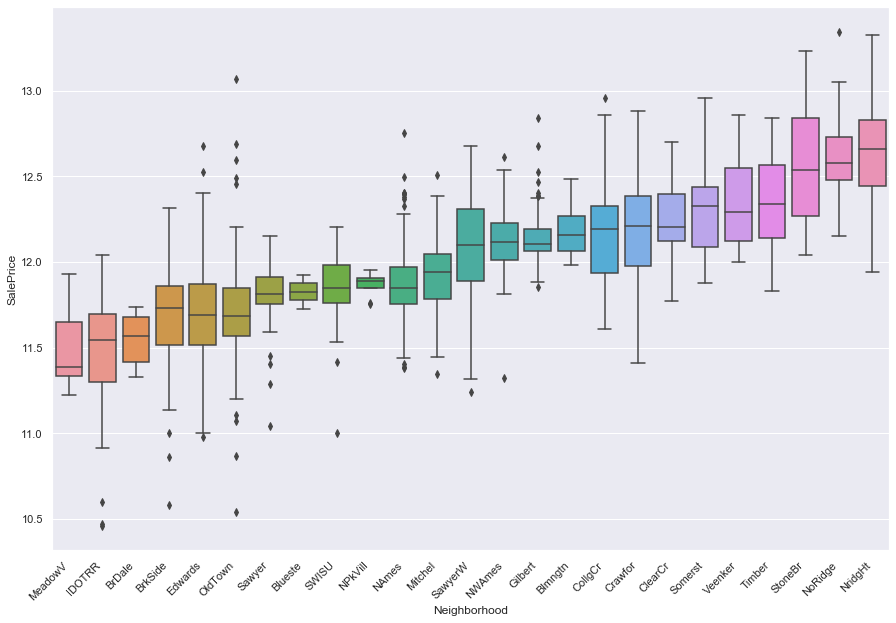

In [151]:
# Find the order
my_order = train.groupby(by=["Neighborhood"])["SalePrice"].mean().sort_values().index
 
plt.figure(figsize=(15,10))
ax = sns.boxplot(x="Neighborhood", y=np.log(train['SalePrice']), data=train, order=my_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

It's clear location matters in the price of the home. While there are outliers, the sale price of a home can be roughly correlated with where it is in Ames. This led me to create a new feature called PriceRange that I would be able to segment a model by. 

In [152]:
hood_means = train.groupby(by=["Neighborhood"])["SalePrice"].mean().reset_index()
hood_means['PriceRange'] = pd.qcut(hood_means.SalePrice,5,labels=['Cheap','LowerMiddle','Middle','UpperMiddle','Expensive'])


### Let's visualize our new set and create some new columns

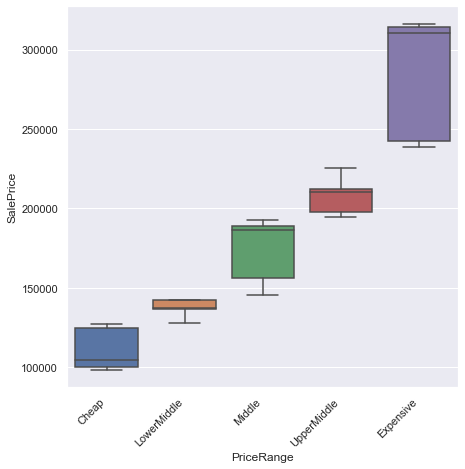

In [153]:
# Find the order
#my_order = train.groupby(by=["Neighborhood"])["SalePrice"].mean().sort_values().index
 
plt.figure(figsize=(7,7))
ax = sns.boxplot(x="PriceRange", y='SalePrice', data=hood_means)#, order=my_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

In [154]:
train = train.merge(hood_means[['Neighborhood','PriceRange']], on = 'Neighborhood')
test = test.merge(hood_means[['Neighborhood','PriceRange']], on = 'Neighborhood')

### Exploration of Price Segmentation

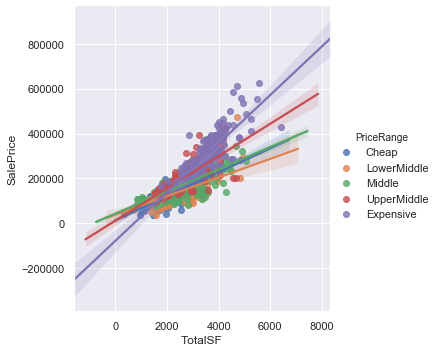

In [155]:
sns.lmplot(x="TotalSF", y="SalePrice", hue="PriceRange",
           data=train);

Segmenting shows different linear regressions for TotalSF v SalePrice

In [85]:
n_filter = 20
num_points = train.groupby(by=["Neighborhood",'OverallQual']).size().reset_index()
num_points = num_points[num_points[0] > n_filter].sort_values(by=0, ascending=False)

In [87]:
# Seaborn really sucks for good exploration
# plt.figure(figsize=(10,20))
# ax = sns.catplot(x="Neighborhood", y="OverallQual", 
#                  data=num_points, 
#                  palette=['black'], 
#                  height=3, aspect=4)
# for axes in ax.axes.flat:
#     axes.set_xticklabels(axes.get_xticklabels(), rotation=65, horizontalalignment='right')
# plt.grid()  #just add this
# plt.show()

### Interaction between Neighborhood and Various Subjective Measures

In [104]:
from IPython.display import HTML, display
display(HTML("<table><tr><td><img src='./Linear Model/nQ.png'></td><td><img src='./Linear Model/nQ_test.png'></td></tr></table>"))

,


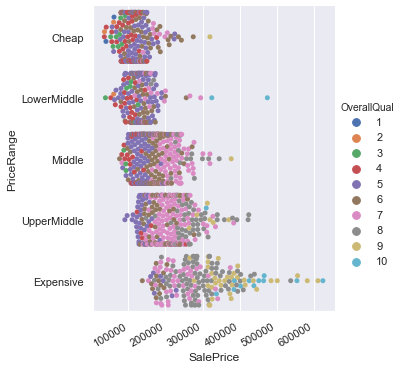

In [119]:
ax = sns.catplot(y="PriceRange", x="SalePrice", hue="OverallQual", kind='swarm',
           data=train);
for axes in ax.axes.flat:
     axes.set_xticklabels(axes.get_xticklabels(), rotation=30, horizontalalignment='right')

In [105]:
from IPython.display import HTML, display
display(HTML("<table><tr><td><img src='./Linear Model/nC.png'></td><td><img src='./Linear Model/nC_test.png'></td></tr></table>"))

,


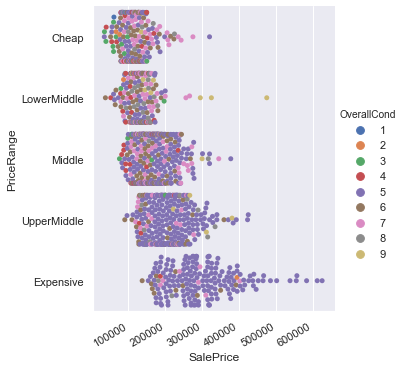

In [120]:
ax = sns.catplot(y="PriceRange", x="SalePrice", hue="OverallCond", kind='swarm',
           data=train);
for axes in ax.axes.flat:
     axes.set_xticklabels(axes.get_xticklabels(), rotation=30, horizontalalignment='right')

### EDA Conclusion

There is some relationship between where a property is located and subjective measures like Overall Quality and Overall Condition. Overall Quality seems to be the more tightly coupled to price and by extension the segments we created. We will explore these interactions (among others) in the modeling sections to follow.

## Modeling GAMs

### Motivation

<img src="./Linear Model/three-lm-problems-1.png">

Three assumptions of the linear model (left side):
- Gaussian distribution of the outcome given the features
- Additivity (no interactions)
- Linear relationship between predictors and response. 

Reality usually does not adhere to those assumptions (right side): 

- Outcomes might have non-Gaussian distributions
- Features might interact
- Relationship might be nonlinear.


### Data Preparation

In [229]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,TotalBathrooms,HasBasement,HasGarage,HasPorch,HasPool,WasRemodeled,IsNew,WasCompleted,AfterWW2,PriceRange
0,60,RL,65.0,8450,2,0.0,1,4,4,Inside,...,3.5,1,1,1,0,0,1,1,1,UpperMiddle
1,60,RL,68.0,11250,2,0.0,2,4,4,Inside,...,3.5,1,1,1,0,1,1,1,1,UpperMiddle
2,20,RL,91.0,10652,2,0.0,2,4,4,Inside,...,2.0,1,1,1,0,1,1,0,1,UpperMiddle
3,20,RL,75.0,9742,2,0.0,1,4,4,Inside,...,2.0,1,1,1,0,0,1,1,1,UpperMiddle
4,20,RL,85.0,11049,2,0.0,1,4,4,Corner,...,2.0,1,1,1,0,0,1,1,1,UpperMiddle


In [231]:
train_dummy = pd.get_dummies(train,drop_first=True)

In [237]:
X_train, X_test, y_train, y_test = train_test_split(train_dummy, train_dummy['SalePrice'], test_size=0.2, random_state=41)

In [239]:

from sklearn.preprocessing import PolynomialFeatures
interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)


In [240]:
X_inter = interaction.fit_transform(X_train)

In [236]:
from pygam import GAM, LinearGAM, s, f, te, l
#X = X_train[['GrLivArea','TotalBsmtSF','OverallQual']]
#X_t = X_test[['GrLivArea','TotalBsmtSF','OverallQual']]
y = np.log(y_train)
#y_t = np.log(y_test)



lams = np.random.rand(30, 3) # random points on [0, 1], with shape (100, 3)
lams = lams * 8 - 3 # shift values to -3, 3
lams = np.exp(lams) # transforms values to 1e-3, 1e3

gam = LinearGAM().fit(X_train, y_train)
gam.gridsearch(X_train, y_train)
#gam.summary()

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

KeyboardInterrupt: 

In [235]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      7.8673
Link Function:                     IdentityLink Log Likelihood:                                 -2556.7408
Number of Samples:                         1164 AIC:                                             5131.2162
                                                AICc:                                            5131.3679
                                                GCV:                                                0.1615
                                                Scale:                                              0.1595
                                                Pseudo R-Squared:                                   0.0067
Feature Function                  Lam

In [217]:
print('Average Difference in Predicted Price: ${}'.format(round(np.sqrt(np.square(np.exp(gam.predict(X_t)) - y_test).mean()),2)))

Average Difference in Predicted Price: $33877.03


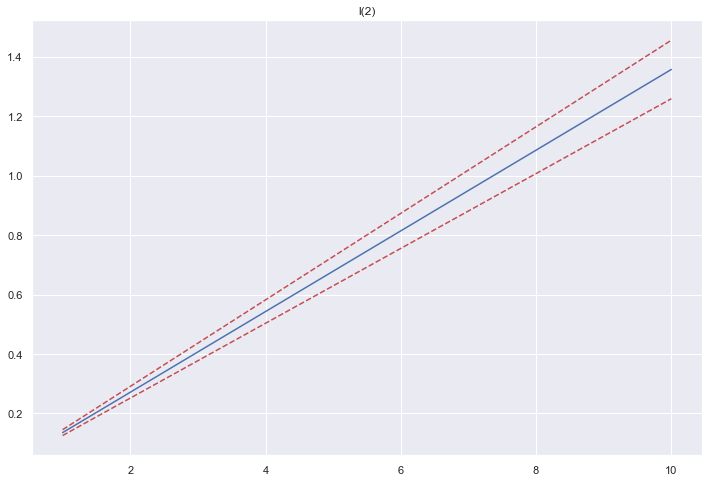

In [221]:
for i, term in enumerate(gam.terms):
    if term.isintercept or term.istensor:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.show()

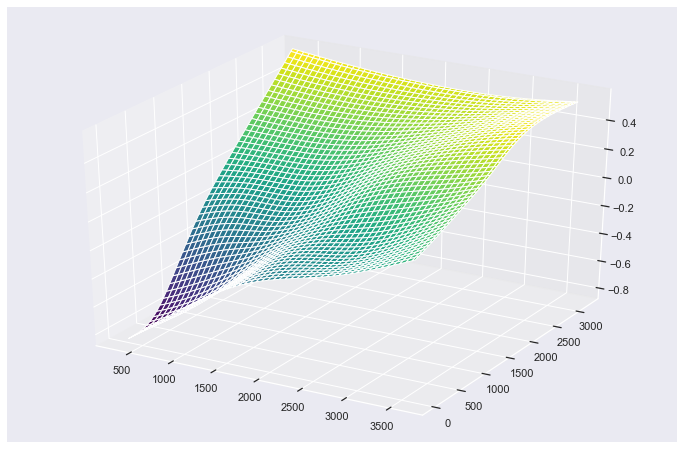

In [220]:

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

plt.ion()
plt.rcParams['figure.figsize'] = (12, 8)

XX = gam.generate_X_grid(term=0, meshgrid=True)
Z = gam.partial_dependence(term=0, X=XX, meshgrid=True)

ax = plt.axes(projection='3d')
ax.plot_surface(XX[0], XX[1], Z, cmap='viridis')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2)

In [130]:
from pygam import LinearGAM, s, f, te
X = X_train[['GrLivArea','TotalBsmtSF','OverallQual','YearBuilt','Fireplaces',
             'TotalPorchSF','MSSubClass','OverallCond']].to_numpy()
X_t = X_test[['GrLivArea','TotalBsmtSF','OverallQual','YearBuilt','Fireplaces',
              'TotalPorchSF','MSSubClass','OverallCond']].to_numpy()
y = np.log(y_train)
y_t = np.log(y_test)



lams = np.random.rand(30, 4) # random points on [0, 1], with shape (100, 3)
lams = lams * 8 - 3 # shift values to -3, 3
lams = np.exp(lams) # transforms values to 1e-3, 1e3

gam = LinearGAM(s(0)+s(1)+te(2,7)).fit(X, y)
gam.gridsearch(X, y, lam=lams)
gam.summary()

100% (30 of 30) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     32.2546
Link Function:                     IdentityLink Log Likelihood:                                -18522.9589
Number of Samples:                         1164 AIC:                                             37112.427
                                                AICc:                                           37114.4436
                                                GCV:                                                0.0274
                                                Scale:                                              0.0261
                                                Pseudo R-Squared:                                   0.8375
Feature Function                  Lam

In [156]:
import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines

In [157]:
# Specify which features to spline
x_spline = train[['GrLivArea', 'TotalBsmtSF']]

# Specify Spline Parameters
# df     : numer of basis functions or degrees of freedom
# degree : degree of the spline
bs = BSplines(x_spline, df=[12, 10], degree=[3, 3])

In [176]:
alpha = np.array([10000000.0, 15848.931924611108])

In [177]:
gam_bs = GLMGam.from_formula('SalePrice ~ GrLivArea + TotalBsmtSF', data=train, smoother=bs, alpha=alpha)

In [178]:
res_bs = gam_bs.fit()

## Generalized Cross Validation

Provides a convenient approximation to leave one out CV for linear fitting under a squared error loss. S is the hat matrix

$$GCV(\hat{f}) = \frac{1}{N}\sum_{i=1} \left[\frac{y_i - \hat{f}(x_i)}{1-trace(S)/N}\right]^2$$

In smoothing problems, GCV can also alleviate tendency of cross validation to undersmooth. Has similarity to AIC from the approximation 

$$1/(1-x)^2 \approx 1+2x$$

GCV is used for smoothness selection in the mgcv package in R. Smoothing parameters are chosen to minimize prediction error. GCV is preferred over CV since there's no need to refit the model onto subsets of the data. It functions like the AIC, in that smaller values indicate better fitting models. 

GAMs fitted using GCV smoothness selection can suffer from under-smoothing. 


In [ ]:
import numpy as np

lam = np.logspace(-3,5,5)
lams = [lam] * 3

gam.gridsearch(X,y, lam=lams)
gam.summary()

In [ ]:
lams = np.random.rand(100,3)
lams = lams*8-3
lams = np.exp(lams)

In [ ]:
random_gam = LinearGAM(s(0) + s(1) + f(2)).gridsearch(X,y,lam=lams)
random_gam.summary()

In [ ]:
from pygam import ExpectileGAM
from pygam.datasets import mcycle

X, y = mcycle(return_X_y=True)

# lets fit the mean model first by CV
gam50 = ExpectileGAM(expectile=0.5).gridsearch(X, y)

# and copy the smoothing to the other models
lam = gam50.lam

# now fit a few more models
gam95 = ExpectileGAM(expectile=0.95, lam=lam).fit(X, y)
gam75 = ExpectileGAM(expectile=0.75, lam=lam).fit(X, y)
gam25 = ExpectileGAM(expectile=0.25, lam=lam).fit(X, y)
gam05 = ExpectileGAM(expectile=0.05, lam=lam).fit(X, y)

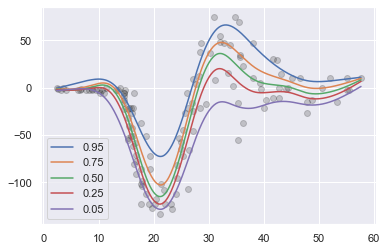

In [193]:

XX = gam50.generate_X_grid(term=0, n=500)

plt.scatter(X, y, c='k', alpha=0.2)
plt.plot(XX, gam95.predict(XX), label='0.95')
plt.plot(XX, gam75.predict(XX), label='0.75')
plt.plot(XX, gam50.predict(XX), label='0.50')
plt.plot(XX, gam25.predict(XX), label='0.25')
plt.plot(XX, gam05.predict(XX), label='0.05')
plt.legend()

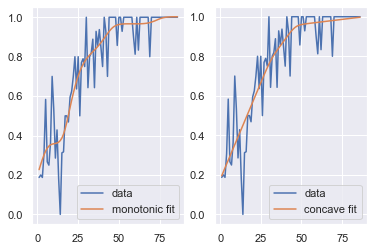

In [194]:

from pygam import LinearGAM, s
from pygam.datasets import hepatitis

X, y = hepatitis(return_X_y=True)

gam1 = LinearGAM(s(0, constraints='monotonic_inc')).fit(X, y)
gam2 = LinearGAM(s(0, constraints='concave')).fit(X, y)

fig, ax = plt.subplots(1, 2)
ax[0].plot(X, y, label='data')
ax[0].plot(X, gam1.predict(X), label='monotonic fit')
ax[0].legend()

ax[1].plot(X, y, label='data')
ax[1].plot(X, gam2.predict(X), label='concave fit')
ax[1].legend()

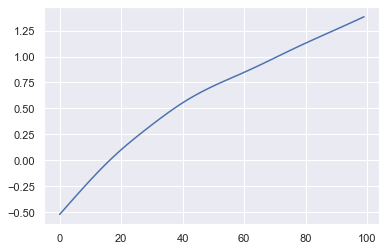

In [195]:
plt.figure()
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    plt.plot(gam.partial_dependence(term=i))

In [ ]:
_ = plt.plot(gam.logs_['deviance'])

In [ ]:
gam.logs_

In [ ]:
from pygam import LinearGAM
from pygam.datasets import mcycle

X, y = mcycle()

gam = LinearGAM()
gam.gridsearch(X, y)

XX = gam.generate_X_grid(term=0)

m = X.min()
M = X.max()
XX = np.linspace(m - 10, M + 10, 500)
Xl = np.linspace(m - 10, m, 50)
Xr = np.linspace(M, M + 10, 50)

plt.figure()

plt.plot(XX, gam.predict(XX), 'k')
plt.plot(Xl, gam.confidence_intervals(Xl), color='b', ls='--')
plt.plot(Xr, gam.confidence_intervals(Xr), color='b', ls='--')
_ = plt.plot(X, gam.confidence_intervals(X), color='r', ls='--')

In [ ]:
gam_bs.select_penweight()[0]